In [1]:
!pip install transformers
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
import torchtext.data as ttd

## Loading Dataset

We will use The 20 Newsgroups dataset 
Dataset [homepage](http://qwone.com/~jason/20Newsgroups/): 

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset-- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html. We'll use them below to retrieve the dataset.

Also look at results fron non- neural net models here : https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  2 01:15:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [5]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [6]:
print(train.target[0])

7


In [7]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
len(train.target_names)

20

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


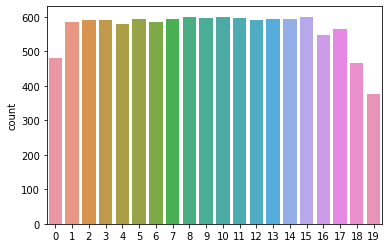

In [9]:
import seaborn as sns

# Plot the number of tokens of each length.
sns.countplot(train.target);

#BERT with 140 features

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [11]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
docoder_sent=[]
before_trunc=[]
maxlen=140

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    docoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#print(input_ids)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [12]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []
test_decoder_sent=[]
test_before_trunc=[]
maxlen=140

# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    test_before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    test_decoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
#print(input_ids)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test.target)

In [13]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [15]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [16]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [17]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [18]:
n_outputs = 20
dropout_rate = 0.5

In [19]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [20]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [21]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [22]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 2.8169    Valid Loss: 2.3916, Duration: 0:00:33.408414
Epoch 2/10, Train Loss: 2.6087    Valid Loss: 2.2411, Duration: 0:00:33.444696
Epoch 3/10, Train Loss: 2.5485    Valid Loss: 2.1191, Duration: 0:00:33.461446
Epoch 4/10, Train Loss: 2.5170    Valid Loss: 2.0605, Duration: 0:00:33.362643
Epoch 5/10, Train Loss: 2.5109    Valid Loss: 2.0442, Duration: 0:00:33.420326
Epoch 6/10, Train Loss: 2.4841    Valid Loss: 1.9653, Duration: 0:00:33.425726
Epoch 7/10, Train Loss: 2.4805    Valid Loss: 1.9527, Duration: 0:00:33.450313
Epoch 8/10, Train Loss: 2.4489    Valid Loss: 1.9174, Duration: 0:00:33.355541
Epoch 9/10, Train Loss: 2.4518    Valid Loss: 1.9252, Duration: 0:00:33.429696
Epoch 10/10, Train Loss: 2.4513    Valid Loss: 1.9301, Duration: 0:00:33.472276


In [23]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [24]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.4783,	 Valid acc: 0.4452,	 Test acc: 0.4092


In [25]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [26]:
y_test, predictions=get_predictions(test_dataloader, model)

In [27]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 72,  21,   5,   0,   1,   0,   1,   0,   0,  48,   1,   3,   1,
         16,   4,  50,  11,  22,  27,  36],
       [  1, 259,  23,   7,   7,   5,   8,   0,   0,  40,   0,   4,   7,
          4,   2,   1,   0,   3,   3,  15],
       [  2, 134, 126,  16,  17,   4,   9,   0,   0,  38,   1,   3,   4,
          0,   4,   1,   1,   0,   5,  29],
       [  0, 108,  68,  77,  51,   0,   9,   2,   0,  36,   2,   4,  13,
          3,   1,   0,   2,   0,   2,  14],
       [  0,  97,  42,  44,  89,   1,   8,   1,   4,  45,   0,   3,  10,
          5,   4,   0,   0,   0,   5,  27],
       [  0, 165,  76,   9,   8,  67,   6,   0,   0,  22,   1,   6,   1,
          3,   8,   1,   0,   1,   2,  19],
       [  1,  52,  13,  19,   6,   0, 221,   4,   1,  40,   0,   0,   3,
          2,   2,   0,   1,   2,   3,  20],
       [  0,  37,   6,  14,  10,   0,  16, 138,  11,  89,   0,   1,   9,
         16,   0,   0,   3,   1,   6,  39],
       [  1,  41,   8,  20,   4,   0,   8,  11,  81, 132,   2,  

In [28]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

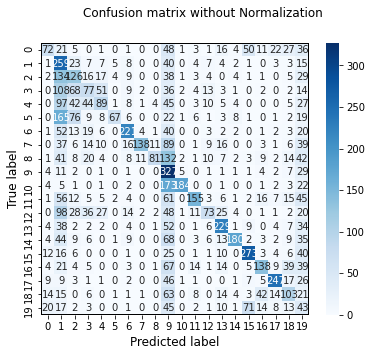

In [29]:
plot_confusion_matrix(y_test,predictions)

#BERT with 128

In [30]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [31]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
docoder_sent=[]
before_trunc=[]
maxlen=128

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    docoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#print(input_ids)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [32]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []
test_decoder_sent=[]
test_before_trunc=[]
maxlen=128
test_labels = torch.tensor(test.target)
# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    test_before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    test_decoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
#print(input_ids)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [33]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [35]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [36]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [37]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [38]:
n_outputs = 20
dropout_rate = 0.5

In [39]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [40]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [41]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [42]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 2.7723    Valid Loss: 2.3595, Duration: 0:00:30.957401
Epoch 2/10, Train Loss: 2.5724    Valid Loss: 2.1447, Duration: 0:00:31.078342
Epoch 3/10, Train Loss: 2.5064    Valid Loss: 2.0680, Duration: 0:00:30.977611
Epoch 4/10, Train Loss: 2.4700    Valid Loss: 1.9957, Duration: 0:00:30.962295
Epoch 5/10, Train Loss: 2.4389    Valid Loss: 1.9679, Duration: 0:00:31.048614
Epoch 6/10, Train Loss: 2.4290    Valid Loss: 1.9644, Duration: 0:00:31.023816
Epoch 7/10, Train Loss: 2.4126    Valid Loss: 1.9506, Duration: 0:00:30.992088
Epoch 8/10, Train Loss: 2.4059    Valid Loss: 1.9297, Duration: 0:00:30.942897
Epoch 9/10, Train Loss: 2.4054    Valid Loss: 1.9053, Duration: 0:00:31.043710
Epoch 10/10, Train Loss: 2.3881    Valid Loss: 1.8428, Duration: 0:00:31.040517


In [43]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [44]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.5290,	 Valid acc: 0.4841,	 Test acc: 0.4446


In [45]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [46]:
y_test, predictions=get_predictions(test_dataloader, model)

In [47]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 52,   2,   5,   0,   1,   0,   2,   1,   0,  15,   4,   5,   0,
         23,  66,  53,  25,  24,  18,  23],
       [  0, 156,  42,   4,  18,  32,  29,   0,   0,  16,   0,   5,   1,
          6,  67,   1,   7,   2,   1,   2],
       [  2,  61,  78,  37,  23,  58,  21,   1,   0,  18,   1,   6,   2,
         10,  63,   1,   6,   2,   4,   0],
       [  1,  31,  56,  92,  75,  13,  41,   2,   1,  13,   1,   4,   7,
          6,  37,   3,   8,   0,   1,   0],
       [  1,  21,  31,  35, 125,  16,  33,   3,   1,  15,   1,   4,   6,
          8,  76,   1,   8,   0,   0,   0],
       [  0,  71,  59,  11,  12, 139,  20,   0,   1,   8,   1,   7,   2,
          2,  53,   1,   4,   3,   1,   0],
       [  0,  15,   6,  10,   6,   3, 283,   7,   1,  11,   1,   2,   3,
          2,  32,   1,   6,   0,   1,   0],
       [  0,   2,   3,   2,  10,   1,  29, 184,  13,  16,   1,   4,   8,
          6,  99,   0,  12,   3,   3,   0],
       [  1,   7,  12,   2,   5,   3,  25,  45,  91,  32,   1,  

In [48]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

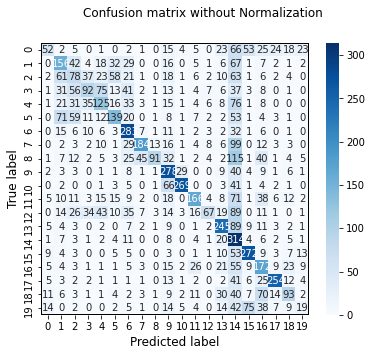

In [49]:
plot_confusion_matrix(y_test,predictions)

#BERT 512 Features

In [50]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [51]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
docoder_sent=[]
before_trunc=[]
maxlen=512
labels = torch.tensor(train.target)
# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    docoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#print(input_ids)
attention_masks = torch.cat(attention_masks, dim=0)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [52]:
# Get last three tokens and truncate head
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []
test_decoder_sent=[]
test_before_trunc=[]
maxlen=512
test_labels = torch.tensor(test.target)
# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=False,
                        padding=False,
                        #max_length = maxlen,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
   
    test_before_trunc.append(encoded_dict['input_ids'])

    ids = encoded_dict['input_ids']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [102]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['input_ids']=torch.tensor([ids])

    ids = encoded_dict['attention_mask']
    if len(ids)>=maxlen:
      ids = [ids[0]] + ids[-(maxlen-1):-1] + [1]
    else:
      ids = ids + ([0] * (maxlen-len(ids)))
    encoded_dict['attention_mask']=torch.tensor([ids])

    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    #print(input_ids)
        
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

    # Get the decoded sentence
    test_decoder_sent.append(tokenizer.decode(encoded_dict['input_ids'].squeeze()))

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
#print(input_ids)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [53]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [54]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [55]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [56]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [57]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [58]:
n_outputs = 20
dropout_rate = 0.5

In [59]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [60]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [61]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [62]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 3.0417    Valid Loss: 2.7780, Duration: 0:02:01.126623
Epoch 2/10, Train Loss: 2.9329    Valid Loss: 2.6847, Duration: 0:02:01.281187
Epoch 3/10, Train Loss: 2.9016    Valid Loss: 2.6381, Duration: 0:02:01.230411
Epoch 4/10, Train Loss: 2.8764    Valid Loss: 2.5830, Duration: 0:02:01.262106
Epoch 5/10, Train Loss: 2.8541    Valid Loss: 2.6120, Duration: 0:02:01.383775
Epoch 6/10, Train Loss: 2.8473    Valid Loss: 2.5413, Duration: 0:02:01.520749
Epoch 7/10, Train Loss: 2.8357    Valid Loss: 2.5198, Duration: 0:02:01.259472
Epoch 8/10, Train Loss: 2.8219    Valid Loss: 2.5013, Duration: 0:02:01.286779
Epoch 9/10, Train Loss: 2.8168    Valid Loss: 2.5052, Duration: 0:02:01.248354
Epoch 10/10, Train Loss: 2.8272    Valid Loss: 2.4822, Duration: 0:02:01.276187


In [63]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [64]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.2495,	 Valid acc: 0.2412,	 Test acc: 0.2211


In [65]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [66]:
y_test, predictions=get_predictions(test_dataloader, model)

In [67]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 35,   0,   0,   0,   0,   0,   7,   1,   0,  23,   0,   1,   0,
          3,   0,   9,   0, 212,  22,   6],
       [  0,  30,   5,  38,   1,   3,  41,   0,   1,  18,   3,   4,   6,
          5,   5,   0,   0, 221,   8,   0],
       [  0,   5,  15,  81,   1,   6,  25,   0,   0,  30,   1,   4,   4,
          4,   3,   0,   0, 210,   5,   0],
       [  0,   2,   4, 113,   4,   2,  24,   1,   0,  20,   0,   4,   4,
          1,   0,   0,   0, 212,   1,   0],
       [  0,   1,   1,  76,   8,   0,  27,   2,   2,  25,   3,   0,   9,
          3,   0,   0,   0, 224,   4,   0],
       [  1,   6,   9,  82,   0,  32,  40,   1,   0,  15,   2,   7,   7,
          3,   1,   0,   0, 187,   2,   0],
       [  0,   2,   0,  13,   1,   0, 223,   6,   0,  18,   3,   1,   0,
          1,   0,   0,   0, 118,   4,   0],
       [  0,   0,   0,   7,   0,   0,  29,  80,   0,  35,   1,   1,   3,
          2,   0,   0,   0, 235,   3,   0],
       [  0,   1,   0,  10,   0,   1,  34,  47,   7,  37,   1,  

In [68]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

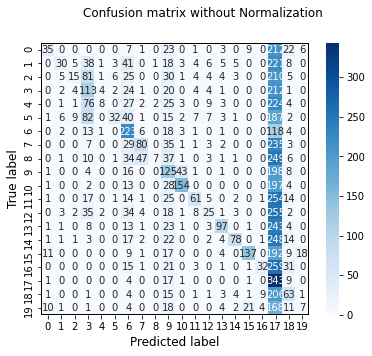

In [69]:
plot_confusion_matrix(y_test,predictions)